In [1]:
%config Completer.use_jedi = False

In [2]:
from utils import *
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.constraint_handling import *
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "../datasets/UK50_1.txt"
meta_data, distance_data, station_data = parse_UK_Data(dataset)

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
location_context = "United Kingdom"
#station_coordinates = generate_coordinates(station_data,location_context,to_csv=True,filename=dataset)
station_coordinates = pd.read_csv('../datasets/UK50_1_coordinates.csv', encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()

#UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")

In [3]:
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000
#distance_matrix_here,time_matrix_here,_ = generate_large_distance_matrix(points_coordinate,api)
distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/",dataset)

In [4]:
#save_here_data("../datasets/",dataset,distance_matrix_here,time_matrix_here)

In [5]:
import math
import random
from jmetal.core.problem import PermutationProblem
from jmetal.core.solution import PermutationSolution
from itertools import chain
import collections

class VRP(PermutationProblem):
    
    def __init__(self,problemData):
        check_type(problemData,dict)
        fuel_eq_types = {0:'linear',1:'rakha'}
        super(VRP,self).__init__()
        
        self.distance_matrix = problemData['distance_matrix']
        self.time_matrix = problemData['time_matrix']
        self.demands = problemData['demands']
        self.max_no_of_vehicle = problemData['vehicle_amount']
        self.vehicle_capacities = problemData['vehicle_capacities']
        self.object_directions=[self.MINIMIZE]
        self.number_of_objectives = problemData['objective_amount']
        self.objective_functions=problemData['objective_functions']
        self.objective_labels = problemData['objective_labels']
        self.number_of_constraints = problemData['constraint_amount']
        self.constraint_functions= problemData['constraint_functions']
        self.start_positions = problemData['start_points']
        self.end_positions = problemData['end_points']
        self.number_of_variables = problemData['number_of_cities'] - len(self.start_positions)
        self.depot = 0
        self.cost_history = []
        self.fuel_eq_type = fuel_eq_types[problemData['fuelEq']]
        
        cost_function_dict = {"distance_matrix":self.distance_matrix,"time_matrix":self.time_matrix,
                              "demands":self.demands,"vehicle_weight":3000,"start_positions":self.start_positions,"meta_data":meta_data}
        self.first_sol  =cheapest_arc(list(range(self.number_of_variables+len(self.start_positions))),fuel_consumption_rakha,cost_function_dict)
        #print(self.first_sol)
        #print(len(self.first_sol))
    def evaluate(self, solution: PermutationSolution) -> PermutationSolution:
        fitness = 0
        
        permutation = list(map(int, solution.variables))
        # Start positions = [0,6] -> paths = [[0],[6]]
        start_positions = self.start_positions
        paths = list([[x] for x in start_positions])
        vehicles = 1
        current_load = 0
        vehicle_index=0
        ends = []
        #======================Construct paths==========================#
        for node_index in permutation:
            
            if self.end_positions != None:
                if node_index in self.end_positions:
                    ends.append(node_index)
                    continue
            
            if not node_index in start_positions:
                load = current_load + demand_callback(node_index,self.demands,self.start_positions)

                if load <= self.vehicle_capacities[vehicle_index]:
                    paths[vehicle_index].append(node_index)
                    current_load = load

                else:
                    if vehicle_index +1 == self.max_no_of_vehicle:
                        print("COULD NOT WITHOLD LOAD CONSTRAINT")
                        break
                        
                    vehicles +=1
                    vehicle_index+=1
                    # Either set the load to the routes first node
                    # And add the node to the new vehicle
                    current_load = demand_callback(node_index,self.demands,self.start_positions)
                    paths[vehicle_index].append(node_index)
                    
                    # Or reset current load and decrement the node_index
                    #current_load = 0
                    #node_index-=1
                    
        solution.path=paths
        #================================================================#
        
        
        if self.end_positions != None:
            for path, end_point in zip(solution.path,ends):
                path.append(end_point)
        

            
        
        #======================CALCULATE FITNESS=========================#
        vehicle_empty_weight = 3000
        solution.vehicle_loads = []
        solution.vehicle_fuel_consumptions = []
        solution.vehicle_route_distances = []
        solution.vehicle_route_times = []
        
        
        dist = 0
        for vehicle_route in paths:
            vehicle_load = 0
            vehicle_fuel_consumption = 0
            vehicle_route_distance = 0
            vehicle_route_time = 0
            total_vehicle_weight = vehicle_empty_weight

            for node_index in range(len(vehicle_route)-1):
                from_node = vehicle_route[node_index]
                to_node = vehicle_route[node_index + 1]
                
                if self.fuel_eq_type == 'linear':
                
                    vehicle_fuel_consumption += fuel_consumption_linear(from_node=from_node,to_node=to_node,
                                                                        distance_matrix=self.distance_matrix,demands=self.demands,
                                                                        cumulative_route_load=vehicle_load,meta_data=meta_data)
                
                elif self.fuel_eq_type == 'rakha':
                    
                    vehicle_fuel_consumption += fuel_consumption_rakha(from_node=from_node,to_node=to_node,
                                                                     distance_matrix=self.distance_matrix,time_matrix= self.time_matrix,
                                                                     demands=self.demands,vehicle_weight = vehicle_empty_weight,
                                                                     start_positions=self.start_positions,meta_data=meta_data)

                vehicle_load += demand_callback(from_node,self.demands,self.start_positions)
                vehicle_route_distance += self.distance_matrix.iloc[from_node][to_node]
                vehicle_route_time += self.time_matrix.iloc[from_node][to_node]
                

            #Increment fitness value
            fitness += vehicle_fuel_consumption
            dist += vehicle_route_distance
            solution.vehicle_route_distances.append(round(vehicle_route_distance,2))
            solution.vehicle_fuel_consumptions.append(vehicle_fuel_consumption)
            solution.vehicle_route_times.append(vehicle_route_time)
            solution.vehicle_loads.append(vehicle_load)
        #=================================================================#
        
        
        fitness += max(solution.vehicle_fuel_consumptions) # + max(solution.vehicle_route_times)
        
        #============CHECK CONSTRAINTS==============
        solution.constraints[0] = 1
        # All nodes must be visited
        if not self.__allVisited(permutation,paths):
            solution.constraints[0] = -100  
            fitness += 10e10
        
        # If end nodes are set, all paths must end at the one of the end nodes
        if self.end_positions != None:
            usedPaths = list(filter(lambda path: len(path) > 1,paths))
            final_path_positions = [path[-1]  for path in paths]
            all_except_last_position = [path[:-1] for path in paths]
            if not (self.__checkEndPoints(final_path_positions) and self.__containsNoEndPoints(all_except_last_position)):
                solution.constraints[0] = -100  
                fitness += 20e10
        # Add drive time constraint
        
        # If cumulative drive time > 8 hours, add 10e10 to fitness
        #===========================================
        
        
            
        solution.objectives[0] = fitness
        #solution.objectives[1] = max(solution.vehicle_route_times)
        
        
        # Update objective fitness
        if fitness < 10e10:
            self.cost_history.append(fitness)
        return solution
    
    def __checkEndPoints(self,ends):
        return set(ends).issubset(set(self.end_positions))
    
    def __containsNoEndPoints(self,paths):
        return set(self.end_positions).isdisjoint(set(chain.from_iterable(paths)))
    
    def __allVisited(self,variables,paths):
        return set(variables).issubset(set(chain.from_iterable(paths)))
    
    def get_route(self, solution: PermutationSolution) -> PermutationSolution:
        routes = []
        for index in range(len(solution.path) - 1):
            if solution.path[index] == 0 :
                routes.append([0])
            else:
                routes[-1].append(solution.path[index])
                

        return routes
    
    def create_solution(self) -> PermutationSolution:
        new_solution = PermutationSolution(number_of_variables=self.number_of_variables,number_of_objectives=self.number_of_objectives,number_of_constraints=self.number_of_constraints)

        
        #new_solution.variables =  list(pd.DataFrame(points_coordinate[range(self.number_of_variables)]).sort_values([0,1]).index.values)
        
        nodes = {}
        points = copy(self.first_sol)#list(range(self.number_of_variables + len(self.start_positions)))
        for start in self.start_positions:
         
            points.remove(start)
            
        
        new_solution.variables = points#random.sample(points, k=self.number_of_variables)
        #new_solution.variables[1] = ar

        #new_solution.variables=self.first_sol
        
        
        self.start_positions = random.sample(self.start_positions,k=len(self.start_positions))
        #new_solution.variables = random.sample(range(self.number_of_variables), k=self.number_of_variables)
        return new_solution
        
    def get_name(self):
        return 'VRP'

In [6]:

starts =[0,6,10,15,20,35,40]
vehicle_amount = len(starts)
ends = [4,2,25,30,32,45,1]
customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
#customer_demands[starts] = 0
#customer_demands[ends] = 0
customer_demands = customer_demands.tolist()

vehicle_capacities = [meta_data['Max Load(kg)'].astype(int)[0] for x in range(vehicle_amount)]


distance_matrix = distance_matrix_here

data_model_input = {'distance_matrix':distance_matrix,'time_matrix':time_matrix_here,'vehicle_amount':vehicle_amount,
                   'demands':customer_demands,'vehicle_capacities':vehicle_capacities,
                    'objective_amount':1,'objective_labels':['Fuel'],'constraint_amount':1,
                    'objective_functions':[],'constraint_functions':[],
                    'number_of_cities':distance_matrix.shape[0],
                    'start_points':starts,'end_points':ends,'fuelEq':1}



In [7]:
def cheapest_arc(nodes,transit_cost_function,cost_function_parameter_dict:dict):
    result = []
    
    result.append(nodes[0])
    for from_node in nodes:
        sub_list = []
        remaining_nodes = copy(nodes)
        remaining_nodes.remove(from_node)
        sub_list = sorted(remaining_nodes, key = lambda node: transit_cost_function(from_node,node,**cost_function_parameter_dict))
        
        for x in sub_list:
            if not x in result:
                result.append(x)
                break
                
    for node in nodes:
        if node not in result:
            result.append(node)
  
    return result


In [8]:
from jmetal.core.observer import Observer
from IPython.display import clear_output
import logging
LOGGER = logging.getLogger('jmetal')
class PerformanceObserver(Observer):
    def __init__(self, max_iter:int,frequency: float = 1.0) -> None:
        """ Show the number of evaluations, best fitness and computing time.
        :param frequency: Display frequency. """
        self.display_frequency = frequency
        self.performances = []
        self.computing_times = []
        self.max_iter = max_iter
        self.currentBestFitness = 10e10
        self.total_consumptions = []
        self.improvement_times = []
    def update(self, *args, **kwargs):
        computing_time = kwargs['COMPUTING_TIME']
        evaluations = kwargs['EVALUATIONS']
        solutions = kwargs['SOLUTIONS']

        if (evaluations % self.display_frequency) == 0 and solutions:
            self.computing_times.append(computing_time)
            if type(solutions) == list:
                fitness = solutions[0].objectives
                consumption = sum(solutions[0].vehicle_fuel_consumptions)
            else:
                fitness = solutions.objectives
                consumption = sum(solutions.vehicle_fuel_consumptions)
            if len(fitness) == 1:
                self.performances.append(fitness[0])
            else:
                self.performances.append(fitness)
            self.total_consumptions.append(consumption)
            
            if fitness[0] < self.currentBestFitness:
                
                self.currentBestFitness = fitness[0]
                if len(self.improvement_times) == 0:
                    self.improvement_times.append(computing_time)
                else:
                    self.improvement_times.append(computing_time - self.improvement_times[-1])
                    
            clear_output(wait=True)
            print('Evaluations: {}/{} \nBest fitness: {}\nBest total fuel consumption:{} \nComputing time: {}s'.format(
                    evaluations,self.max_iter, round(fitness[0],4),round(consumption,2), round(computing_time,2)
                ),flush=True)
            

In [12]:
from jmetal.algorithm.singleobjective import SimulatedAnnealing
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation,SimpleRandomMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.comparator import DominanceComparator

from datetime import datetime

problem_SA = VRP(data_model_input)
max_evaluations = 5000

algorithm_SA = SimulatedAnnealing(problem=problem_SA,
                               mutation=PermutationSwapMutation(0.5),
                               termination_criterion=StoppingByEvaluations(max_evaluations))

performance_observer_SA = PerformanceObserver(max_iter=max_evaluations,frequency=20)
algorithm_SA.observable.register(observer=performance_observer_SA)
algorithm_SA.run()

solutions_SA = algorithm_SA.get_result()
print("Feasible solution found: {}".format(is_feasible(solutions_SA)))

Evaluations: 5000/5000 
Best fitness: 228.3009
Best total fuel consumption:186.53 
Computing time: 196.55s
Feasible solution found: True


In [120]:
get_results(solutions_SA.path,problem_SA.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Rakha et al.),Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,367.296,4181,50.743393,1.381539,34.638629,0.943071,64.116065,20623,05:43:43.00
1,407.306,3566,56.102323,1.377400,37.535297,0.921550,52.068520,28161,07:49:21.00
2,495.447,3175,66.874641,1.349784,45.015189,0.908577,56.300795,31680,08:48:00.00
3,408.477,3662,56.997671,1.395370,39.158792,0.958654,65.519390,22444,06:14:04.00
4,471.277,4153,65.231047,1.384134,44.790557,0.950408,63.176213,26855,07:27:35.00
5,344.393,1343,44.492775,1.291919,32.332042,0.938812,66.685392,18592,05:09:52.00
6,92.554,0,11.569250,1.250000,8.466701,0.914785,64.988180,5127,01:25:27.00


In [17]:
from jmetal.algorithm.singleobjective import LocalSearch
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from datetime import datetime

problem_LS = VRP(data_model_input)
max_evaluations = 5000

algorithm_LS = LocalSearch(problem=problem_LS,
                               mutation=PermutationSwapMutation(0.5),
                               termination_criterion=StoppingByEvaluations(max_evaluations)
                          ,comparator=DominanceComparator())
performance_observer_LS = PerformanceObserver(max_iter=max_evaluations,frequency=20)
algorithm_LS.observable.register(observer=performance_observer_LS)

start_time = datetime.now() 
algorithm_LS.run()
run_time = datetime.now() - start_time

solutions_LS = algorithm_LS.get_result()
print("Feasible solution found: {}".format(is_feasible(solutions_LS)))

Evaluations: 5000/5000 
Best fitness: 232.6942
Best total fuel consumption:193.51 
Computing time: 196.58s
Feasible solution found: True


In [15]:
get_results(solutions_LS.path,problem_LS.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Rakha et al.),Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,619.174,4119,86.335704,1.394369,59.634094,0.963123,67.048470,33245,09:14:05.00
1,660.128,3440,91.105482,1.380118,60.707420,0.919631,54.250903,43805,12:10:05.00
2,562.936,3551,74.401672,1.321672,53.350361,0.947716,67.386101,30074,08:21:14.00
3,441.884,3735,60.823027,1.376448,41.301816,0.934676,57.660024,27589,07:39:49.00
4,623.584,3254,84.752579,1.359120,58.590842,0.939582,62.652519,35831,09:57:11.00
5,139.599,1429,18.144932,1.299790,13.120010,0.939836,69.089414,7274,02:01:14.00
6,69.719,552,8.978470,1.287808,6.270005,0.899325,60.464563,4151,01:09:11.00


In [19]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

problem_NSGAIII = VRP(data_model_input)
max_evaluations = 5000

algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                        population_size=20,
                        reference_directions=UniformReferenceDirectionFactory(1, n_points=100),
                        mutation=PermutationSwapMutation(0.7),
                        crossover=PMXCrossover(1),
                        termination_criterion=StoppingByEvaluations(max_evaluations),
                        population_evaluator=MultiprocessEvaluator()
                           )

performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=1)
algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
algorithm_NSGAIII.run()

solutions_NSGAIII = algorithm_NSGAIII.get_result()
front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)
print("Feasible solution found: {}".format(is_feasible(front_NSGAIII[0])))

Evaluations: 5000/5000 
Best fitness: 221.6242
Best total fuel consumption:171.6 
Computing time: 42.9s
Feasible solution found: True


In [85]:
get_results(front_NSGAIII[0].path,problem_NSGAIII.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Rakha et al.),Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,289.163,3515,38.231907,1.322158,26.039297,0.900506,51.518697,20206,05:36:46.00
1,199.510,3780,27.083345,1.357493,17.742044,0.889281,49.390455,14542,04:02:22.00
2,282.711,3074,38.172117,1.350217,24.781823,0.876578,46.815069,21740,06:02:20.00
3,250.099,3913,34.730648,1.388676,22.088085,0.883174,42.068797,21402,05:56:42.00
4,295.451,3760,40.390933,1.367094,26.398199,0.893488,48.832634,21781,06:03:01.00
5,411.914,1934,54.133423,1.314192,38.128789,0.925649,62.892968,23578,06:32:58.00
6,98.249,104,12.351111,1.257123,8.648234,0.880236,53.974729,6553,01:49:13.00


In [20]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAII, UniformReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

problem_NSGAII = VRP(data_model_input)
max_evaluations = 5000

algorithm_NSGAII = NSGAII(problem=problem_NSGAII,
                        population_size=20,
                        offspring_population_size=20,
                        mutation=PermutationSwapMutation(0.7),
                        crossover=PMXCrossover(1),
                        termination_criterion=StoppingByEvaluations(max_evaluations),
                        population_evaluator=MultiprocessEvaluator()
                           )

performance_observer_NSGAII = PerformanceObserver(max_iter=max_evaluations,frequency=1)
algorithm_NSGAII.observable.register(observer=performance_observer_NSGAII)
start_time = datetime.now() 
algorithm_NSGAII.run()
run_time = datetime.now() - start_time

solutions_NSGAII = algorithm_NSGAII.get_result()
front_NSGAII = get_non_dominated_solutions(solutions_NSGAII)
print("Feasible solution found: {}".format(is_feasible(front_NSGAII[0])))

Evaluations: 5000/5000 
Best fitness: 191.5623
Best total fuel consumption:158.21 
Computing time: 44.97s
Feasible solution found: True


In [114]:
get_results(front_NSGAII[0].path,problem_NSGAII.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Rakha et al.),Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,393.099,3206,53.111029,1.351085,36.391873,0.925769,56.842722,24896,06:54:56.00
1,409.790,4195,56.242793,1.372478,37.877950,0.924326,57.029689,25868,07:11:08.00
2,322.209,3122,42.687346,1.324834,30.194921,0.937122,56.638301,20480,05:41:20.00
3,398.879,4107,55.301402,1.386420,36.600213,0.917577,56.609808,25366,07:02:46.00
4,389.990,3899,51.005974,1.307879,36.995778,0.948634,65.923088,21297,05:54:57.00
5,217.356,1170,27.906540,1.283909,18.960965,0.872346,43.543773,17970,04:59:30.00
6,56.266,381,7.180081,1.276096,5.115366,0.909140,63.398310,3195,53:15.00


In [21]:
from jmetal.algorithm.singleobjective import GeneticAlgorithm
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator.selection import Selection
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.observer import ProgressBarObserver, VisualizerObserver,PrintObjectivesObserver,BasicObserver
from jmetal.util.evaluator import MultiprocessEvaluator
from datetime import datetime
problem_GA = VRP(data_model_input)
max_evaluations = 5000

algorithm_GA = GeneticAlgorithm(problem=problem_GA,
                population_size=20,
                offspring_population_size=20,
                mutation=PermutationSwapMutation(0.7),
                crossover=PMXCrossover(1),
                selection=RandomSolutionSelection(),
                termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations),
                population_evaluator=MultiprocessEvaluator()
                )


performance_observer_GA = PerformanceObserver(max_iter=max_evaluations,frequency=1)
algorithm_GA.observable.register(observer=performance_observer_GA)
start_time = datetime.now() 
algorithm_GA.run()
run_time = datetime.now() - start_time
solutions_GA = algorithm_GA.get_result()
print("Feasible solution found: {}".format(is_feasible(solutions_GA)))

Evaluations: 5000/5000 
Best fitness: 206.8945
Best total fuel consumption:168.63 
Computing time: 43.57s
Feasible solution found: True


In [26]:
get_results(solutions_GA.path,problem_GA.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Rakha et al.),Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,462.252,3517,62.884082,1.360385,42.018920,0.909005,52.109197,31935,08:52:15.00
1,421.418,3278,55.800027,1.324102,38.349540,0.910012,56.012730,27085,07:31:25.00
2,484.173,4040,65.578334,1.354440,46.138070,0.952925,68.340435,25505,07:05:05.00
3,443.246,3174,59.954670,1.352627,41.708797,0.940985,62.343645,25595,07:06:35.00
4,507.029,3677,69.254296,1.365884,46.129193,0.909794,55.807760,32707,09:05:07.00
5,397.428,1731,52.138396,1.311895,37.504240,0.943674,68.934753,20755,05:45:55.00
6,82.815,663,10.727946,1.295411,7.715302,0.931631,69.381894,4297,01:11:37.00


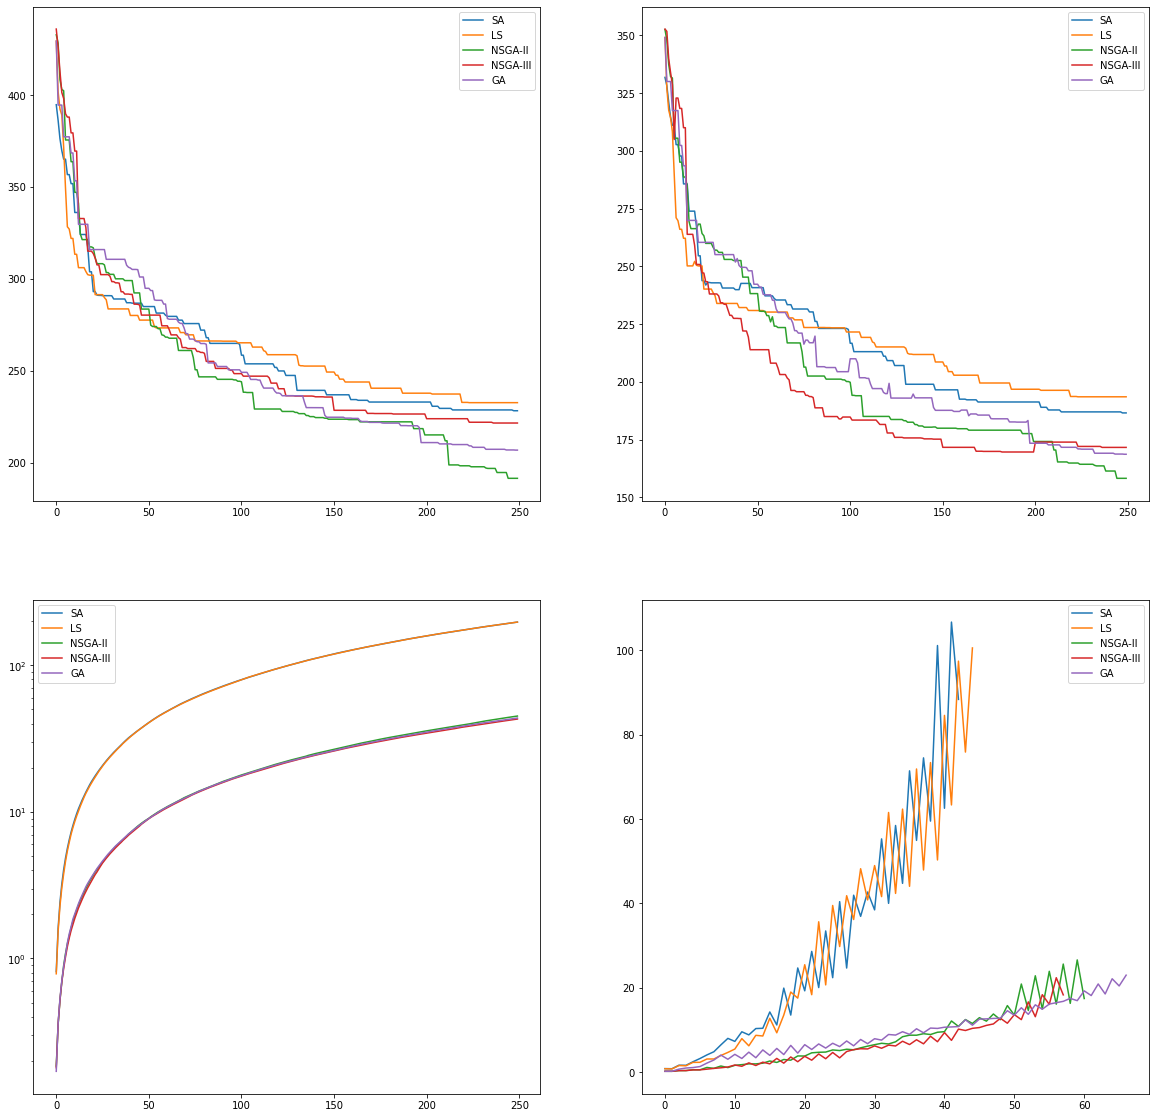

In [24]:

fig ,axs = plt.subplots(ncols=2,nrows=2,figsize=(20,20))
if performance_observer_SA != None:
    axs[0][0].plot(performance_observer_SA.performances,label='SA')
    axs[0][1].plot(performance_observer_SA.total_consumptions,label='SA')
    axs[1][0].plot(performance_observer_SA.computing_times,label='SA')
    axs[1][1].plot(performance_observer_SA.improvement_times,label='SA')

if performance_observer_LS != None:
    axs[0][0].plot(performance_observer_LS.performances,label='LS')
    axs[0][1].plot(performance_observer_LS.total_consumptions,label='LS')
    axs[1][0].plot(performance_observer_LS.computing_times,label='LS')
    axs[1][1].plot(performance_observer_LS.improvement_times,label='LS')
if performance_observer_NSGAII != None:
    axs[0][0].plot(performance_observer_NSGAII.performances,label='NSGA-II')
    axs[0][1].plot(performance_observer_NSGAII.total_consumptions,label='NSGA-II')
    axs[1][0].plot(performance_observer_NSGAII.computing_times,label='NSGA-II')
    axs[1][1].plot(performance_observer_NSGAII.improvement_times,label='NSGA-II')
if performance_observer_NSGAIII != None:
    axs[0][0].plot(performance_observer_NSGAIII.performances,label='NSGA-III')
    axs[0][1].plot(performance_observer_NSGAIII.total_consumptions,label='NSGA-III')
    axs[1][0].plot(performance_observer_NSGAIII.computing_times,label='NSGA-III')
    axs[1][1].plot(performance_observer_NSGAIII.improvement_times,label='NSGA-III')
if performance_observer_GA != None:
    axs[0][0].plot(performance_observer_GA.performances,label='GA')
    axs[0][1].plot(performance_observer_GA.total_consumptions,label='GA')
    axs[1][0].plot(performance_observer_GA.computing_times,label='GA')
    axs[1][1].plot(performance_observer_GA.improvement_times,label='GA')
    

axs[1][0].set_yscale('log')
    
for ax_row in axs:
    for ax in ax_row:
        ax.legend()
plt.show()

In [129]:
algoritm_observers = [performance_observer_SA,performance_observer_LS,performance_observer_GA,performance_observer_NSGAII,performance_observer_NSGAIII]
types =["JMetalPy-SA","LS","GA","NSGAII","NSGAIII"]
metrics = ["Fitness","Fuel Consumption","Computation Time"]#,"DeltaTime"]
columns = []
data = []

for algoType in types:
    for metric in metrics:
        columns.append("{}-{}".format(algoType,metric))

for observer in  algoritm_observers:
    for index in range(len(observer.performances)):
        data.append([observer.performances[index],observer.total_consumptions[index],observer.computing_times[index]])

    
np_data = np.array(data)
np_data= np_data.reshape((250,15))

df_data = pd.DataFrame(np_data,columns=columns)

df_data
df_data.to_csv("../logs/2021-02-08-17-47/JMetalPy_50_1.csv",index=False)

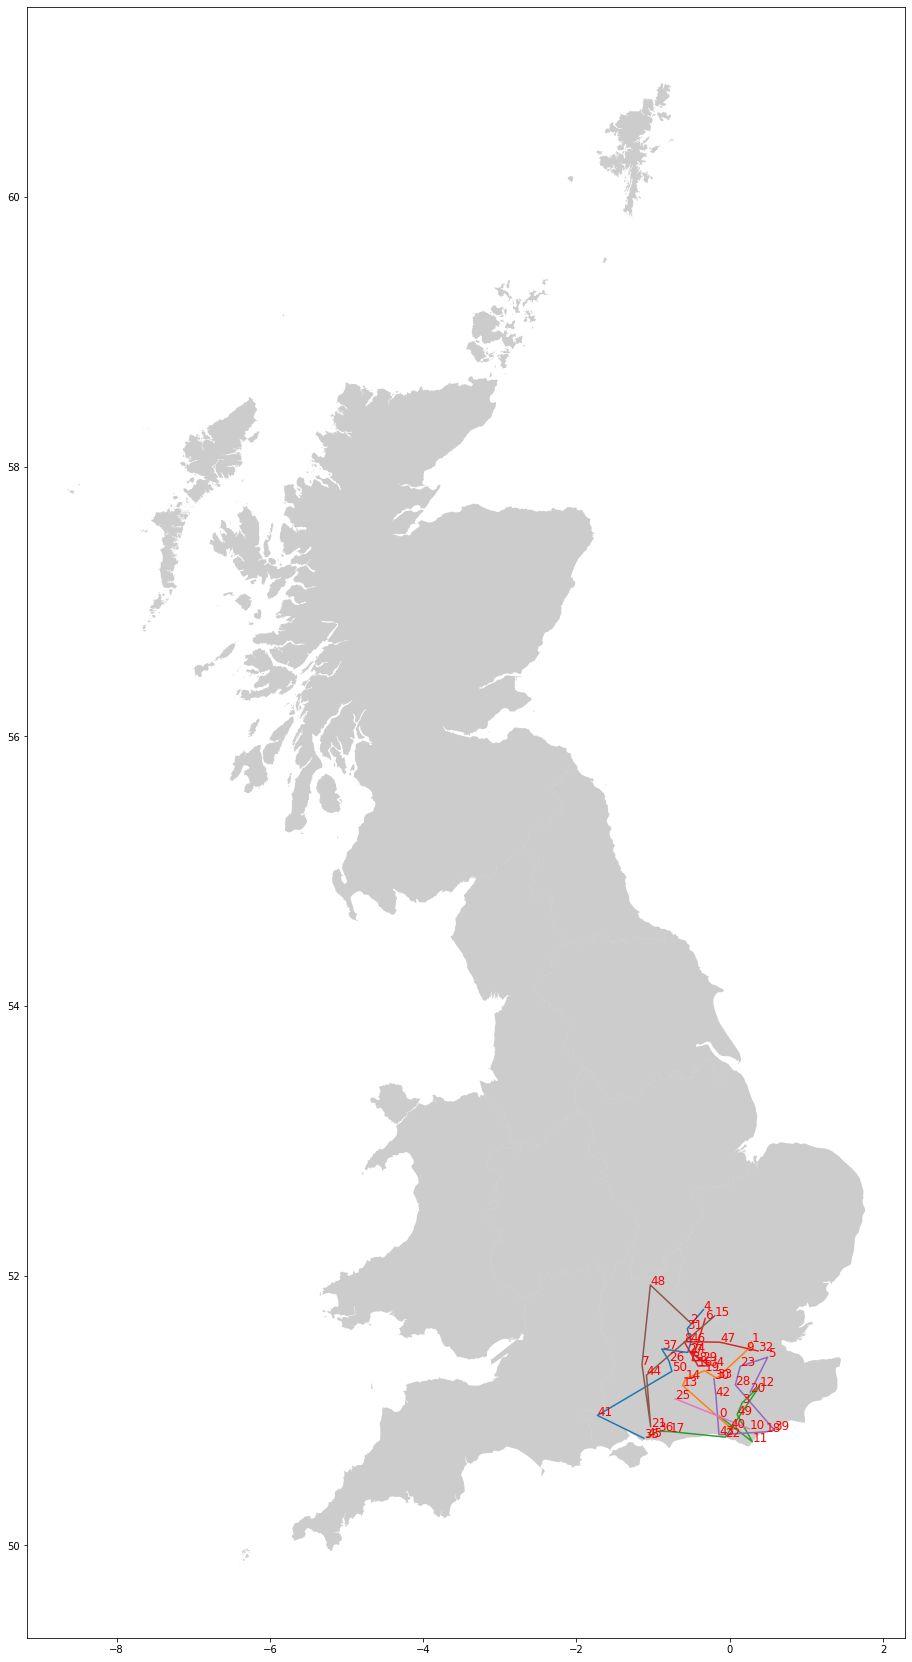

In [87]:
plot_routes(front_NSGAIII[0].path,points_coordinate,dbf,station_ids = True, here_api=False, api_key=api)

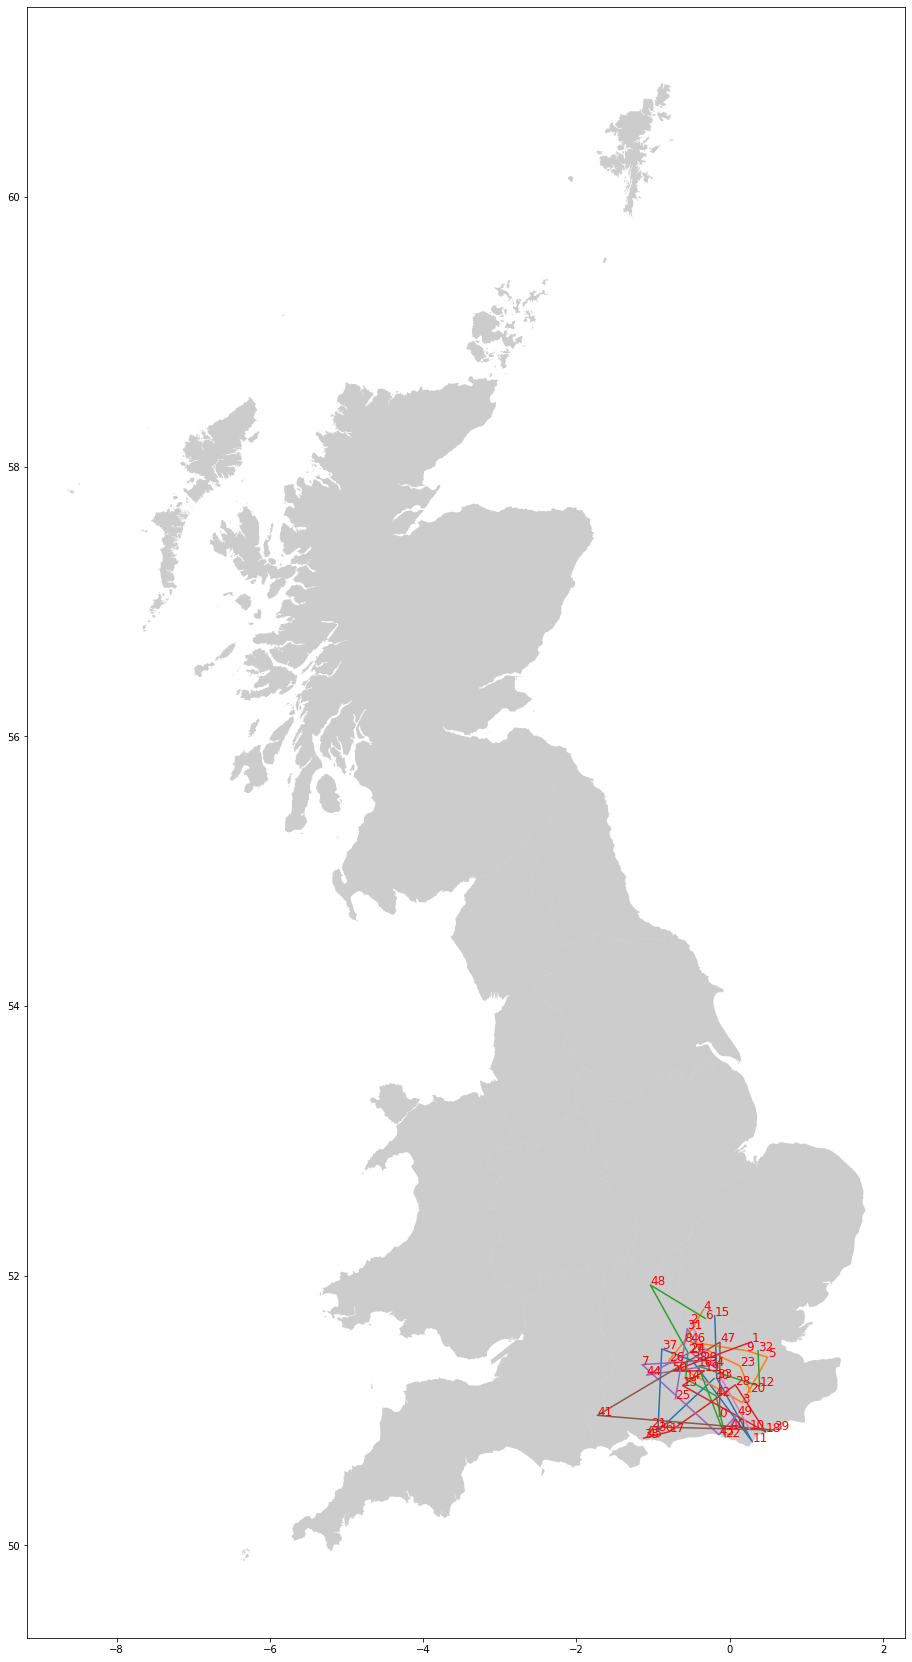

In [78]:
plot_routes(solutions_GA.path,points_coordinate,dbf,station_ids = True, here_api=False, api_key=api)

In [13]:
vehicle_routes = []
vehicle_stops = []
vehicle_stop_demands = []
for v_route in solutions.path:
    vehicle_stop_demands.append(np.array(customer_demands)[v_route[1:]])
    vehicle_stops.append(points_coordinate[v_route[1:]])
    vehicle_routes.append(decode_routes(generate_routes(points_coordinate[v_route],api)))

100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


In [142]:
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

3

In [14]:
import folium
from folium.plugins import PolyLineTextPath
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

centerpoint = [np.mean(points_coordinate[:,0]),np.mean(points_coordinate[:,1])]

folium_map = folium.Map(location=centerpoint, tiles='openstreetmap', zoom_start=8)

# Create popups for the pickup-points
position_popups = []
for solution_path,stop_demands in zip(solutions.path,vehicle_stop_demands):
    position_popups.append(["Node: {}\nDemand: {}(kg)".format(node_id,node_demand) for node_id,node_demand in zip(solution_path[1:],stop_demands)])


markerCluster = MarkerCluster().add_to(folium_map)
# Add pickup-points and start positions to map
for startPos,stop_demands,stop_pos in zip(starts,position_popups,vehicle_stops):
    folium.Marker(location=list(points_coordinate[startPos]),popup="Startpos\nNode: {}".format(startPos),icon=folium.Icon(color='red', icon_color='white', icon='truck', angle=0, prefix='fa')).add_to(markerCluster)
    if len(stop_pos)>1:

        MarkerCluster(stop_pos[:-1],popups=stop_demands[:-1]).add_to(folium_map)
        folium.Marker(location=list(stop_pos[-1]),popup="End\n{}".format(stop_demands[-1]),
                      icon=folium.Icon(color='green', icon_color='white', icon='flag-checkered', angle=0, prefix='fa')).add_to(markerCluster)
        
    else:
        folium.Marker(location=list(stop_pos[0]),popup="{}".format(stop_demands[0]),
                      icon=folium.Icon(color='red', icon_color='white', icon='exclamation-circle', angle=0, prefix='fa')).add_to(markerCluster)
        

colormap = folium.branca.colormap.LinearColormap(colors=['red','green', 'blue'],index=[0,int(len(vehicle_routes)/2),len(vehicle_routes)])
# Add routes to map with popups
for index,(route,route_load,route_fuel_consumption, route_distance) in enumerate(zip(vehicle_routes,solutions.vehicle_loads,
                                                                                     solutions.vehicle_fuel_consumptions,solutions.vehicle_route_distances)):
    
    if(len(route) > 1):
        line = folium.PolyLine(route,color=colormap(index),
                               popup="Route Load: {}(kg)\nFuel consumption: {}(L)\nDistance: {}(km)".format(route_load,route_fuel_consumption,round(route_distance/1000,2))).add_to(folium_map)
        PolyLineTextPath(line, "\u27A4    ",repeat=True).add_to(folium_map)        

# Display the map
folium_map

0
1
